# `epsilon` integration with other NAS methods

In this notebook, we provide examples of how to integrate zero-cost proxies within NAS algorithms. Specifically, we provide implementations of **random search** and **aging evolution search** with and without zero-cost warmup and move proposal for NAS-Bench-101 benchmark.

In [1]:
import pickle
import os
import random
from tqdm import tqdm


import numpy as np
from dotmap import DotMap
import matplotlib.pyplot as plt

import nasspace
from epsinas_utils import prepare_seed

In [2]:
# Select the dataset. Choose among: 'cifar10', 'cifar100', 'ImageNet16-120'
dataset = 'cifar10'

if dataset=='ImageNet16-120':
    data_loc = './datasets/ImageNet16'
else:
    data_loc = './datasets'

In [3]:
# Arguments required for NAS-Bench-201 search space initialisation
args = DotMap()
args.nasspace = 'nasbench201'
args.dataset = dataset
args.api_loc = './api/NAS-Bench-201-v1_1-096897.pth'

In [4]:
if dataset == 'cifar10':
    test_acc_type = 'ori-test'
    val_acc_type = 'x-valid'
else:
    test_acc_type = 'x-test'
    val_acc_type = 'x-valid'

In [5]:
# Load the search space (it takes some time)
searchspace = nasspace.get_search_space(args)

./api/NAS-Bench-201-v1_1-096897.pth


In [6]:
# Retrieve epsinas evaluation of architectures
save_dir = '../epsinas-release-data/NAS-Bench-201'

datafile = open(f'{save_dir}/evaluation/{dataset.upper()}/data_NAS-Bench-201_{dataset.upper()}','rb')
while(1):
    try:
        d = pickle.load(datafile)
        nparams = d['nparams']
        epsinas = d['scores']
        test_accs = d['test_accs']
        val_accs = d['val_accs']
        times = d['times']
    except EOFError:
        break
datafile.close()

# Treat NaNs
epsinas = np.array(epsinas)
epsinas[np.isnan(epsinas)]=0

In [7]:
# Used to sample a random subset of potential parents from the pool
def random_combination(iterable, sample_size):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), sample_size))
    return tuple(pool[i] for i in indices)

# Ageing evolution implementation
def run_evolution_search(dataset,
                         score,
                         max_trained_models=1000, 
                         pool_size=64, 
                         tournament_size=10, 
                         zero_cost_warmup=0, 
                         zero_cost_move=False):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # Fill the initial pool
    # For warmup, retrieve metric values for 3000 random architectures.
    # Make up the pool with the architectures with highest metric values.
    # Otherwise, fill it with random architectures.
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            arch = searchspace.random_arch()
            zero_cost_pool.append((score[arch], arch))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    # Fill the initial pool
    for i in range(pool_size):
        if zero_cost_warmup > 0:
            arch = zero_cost_pool[i][1]
        else:
            arch = searchspace.random_arch()
        
        # Retrieve trained accuracy
        val_acc = val_accs[arch]
        test_acc = test_accs[arch]
        num_trained_models += 1
        
        # Add it to pool
        pool.append((val_acc, score[arch], arch))

        if val_acc > best_valids[-1]:
            best_valids.append(val_acc)
        else:
            best_valids.append(best_valids[-1])
            
        if test_acc > best_tests[-1]:
            best_tests.append(test_acc)
        else:
            best_tests.append(best_tests[-1])

    # After the pool is seeded, proceed with evolving the population.
    while(1):
        sample = random_combination(pool, tournament_size)
        
        if zero_cost_move:
            parent = sorted(sample, key=lambda i:i[1])[-1][2]
        else:
            parent = sorted(sample, key=lambda i:i[0])[-1][2]
        
        child = searchspace.mutate_arch(parent)
        
        val_acc = val_accs[child]
        test_acc = test_accs[child]
        num_trained_models += 1
        
        pool.append((val_acc, score[child], child))
        
        # Kill the oldest individual in the population
        pool.pop(0)

        if val_acc > best_valids[-1]:
            best_valids.append(val_acc)
        else:
            best_valids.append(best_valids[-1])
            
        if test_acc > best_tests[-1]:
            best_tests.append(test_acc)
        else:
            best_tests.append(best_tests[-1])

        if num_trained_models >= max_trained_models:
            break
    best_tests.pop(0)
    best_valids.pop(0)
    
    return best_valids, best_tests

def run_random_search(dataset,
                      score,
                      max_trained_models=1000, 
                      zero_cost_warmup=0):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            arch = searchspace.random_arch()
            zero_cost_pool.append((score[arch], arch))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(max_trained_models):
        if i < zero_cost_warmup:
            arch = zero_cost_pool[i][1]
        else:
            arch = searchspace.random_arch()
            
        val_acc = val_accs[arch]
        test_acc = test_accs[arch]
        
        if val_acc > best_valids[-1]:
            best_valids.append(val_acc)
        else:
            best_valids.append(best_valids[-1])
            
        if test_acc > best_tests[-1]:
            best_tests.append(test_acc)
        else:
            best_tests.append(best_tests[-1])
            
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [8]:
random.seed = 21
num_rounds = 100
length = 300
ae, ae_warmup, ae_move, ae_warmup_move, rand, rand_warmup = [], [], [], [], [], []
for _ in tqdm(range(num_rounds)):
    ae_best_valids, ae_best_tests = run_evolution_search(dataset, epsinas, max_trained_models=length)
    ae.append(ae_best_tests)
    ae_warmup_best_valids, ae_warmup_best_tests = run_evolution_search(dataset, epsinas, max_trained_models=length, zero_cost_warmup=3000)
    ae_warmup.append(ae_warmup_best_tests)
    ae_move_best_valids, ae_move_best_tests = run_evolution_search(dataset, epsinas, max_trained_models=length, zero_cost_move=True)
    ae_move.append(ae_move_best_tests)
    ae_warmup_move_best_valids, ae_warmup_move_best_tests = run_evolution_search(dataset, epsinas, max_trained_models=length, zero_cost_warmup=3000, zero_cost_move=True)
    ae_warmup_move.append(ae_warmup_move_best_tests)
    rand_best_valids, rand_best_tests = run_random_search(dataset, epsinas, max_trained_models=length)
    rand.append(rand_best_tests)
    rand_warmup_best_valids, rand_warmup_best_tests = run_random_search(dataset, epsinas, max_trained_models=length, zero_cost_warmup=3000)
    rand_warmup.append(rand_warmup_best_tests)

100%|█████████████████████████████████████████| 100/100 [03:04<00:00,  1.84s/it]


In [13]:
def plot_experiment(exp_list, dataset, title, filename):
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    def plot_exp(exp, label, linesty):
        exp = np.array(exp) 
        q_75 = np.quantile(exp, .75, axis=0)
        q_25 = np.quantile(exp, .25, axis=0)
        median = np.median(exp, axis=0)
        ax.plot(median, label=label, linestyle=linesty)
        ax.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)
    for exp, ename, linesty in exp_list:
        plot_exp(exp, ename, linesty)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    
    plt.grid()
    plt.xlabel('Trained Models', fontsize = 22)
    
    if dataset=='cifar10':
        plt.title('CIFAR-10', fontsize = 22)
#         plt.ylim(93.5,94.5)
        plt.ylabel('Test Accuracy', fontsize = 22)
    elif dataset=='cifar100':
        plt.title('CIFAR-100', fontsize = 22)
        plt.ylim(70,74)
    elif dataset=='ImageNet16-120':
        plt.title('ImageNet16-120', fontsize = 22)
        plt.ylim(44,47.7)
    
    
    plt.legend(fontsize = 15)
    plt.savefig(filename,
                bbox_inches='tight', 
                dpi=300,
                format='pdf')
    plt.show()

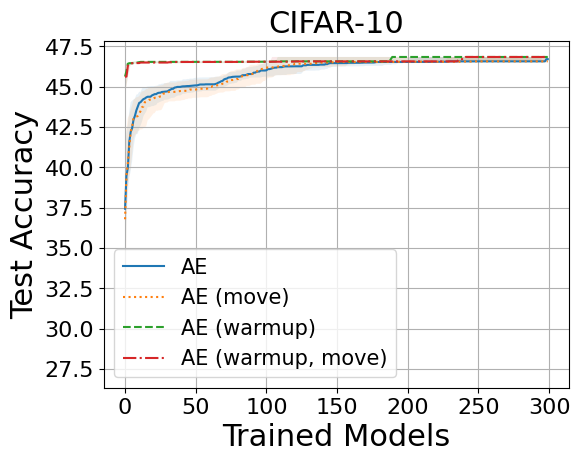

In [14]:
os.makedirs(save_dir, exist_ok=True)
filename=f'{save_dir}/integration/{dataset.upper()}/{dataset.upper()}_EA_Len300_Rounds100_test.pdf'
plot_experiment([(ae,'AE', '-'), (ae_move,'AE (move)', ':'), (ae_warmup,'AE (warmup)', '--'), (ae_warmup_move, 'AE (warmup, move)', '-.')], dataset, 'Aging Evolution Search', filename)

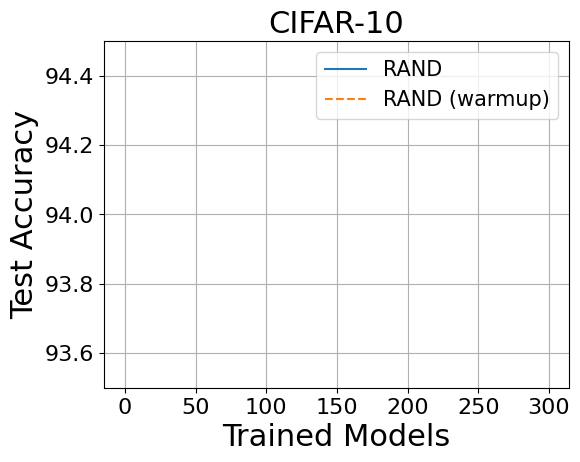

In [30]:
filename=f'{save_dir}/integration/{dataset.upper()}/{dataset.upper()}_RS300+RS_100it_test.pdf'
plot_experiment([(rand,'RAND', '-'), (rand_warmup,'RAND (warmup)', '--')], dataset, 'Random Search', filename)

Comparison with other methods from Zero-shot NAS paper

In [17]:
synflow = []
grasp = []
snip = []
grad_norm = []
fisher = []
jacov = []
acc = []
if dataset=='cifar10':
    datafile = open('../zero-cost-nas-release-data/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','rb')
elif dataset=='cifar100':
    datafile = open('../zero-cost-nas-release-data/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','rb')
elif dataset=='ImageNet16-120':
    datafile = open('../zero-cost-nas-release-data/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','rb')
while(1):
    try:
        d = pickle.load(datafile)
        synflow.append(d['logmeasures']['synflow'])
        grasp.append(d['logmeasures']['grasp'])
        snip.append(d['logmeasures']['snip'])
        grad_norm.append(d['logmeasures']['grad_norm'])
        fisher.append(d['logmeasures']['fisher'])
        jacov.append(d['logmeasures']['jacob_cov'])
        acc.append(d['testacc'])
    except EOFError:
        break
datafile.close()

In [18]:
def plot_exp(exp, label, linesty, clr):
    exp = np.array(exp) 
    q_75 = np.quantile(exp, .75, axis=0)
    q_25 = np.quantile(exp, .25, axis=0)
    median = np.median(exp, axis=0)
    ax.plot(median, label=label, linestyle=linesty, color = clr)
    ax.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)

100%|█████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


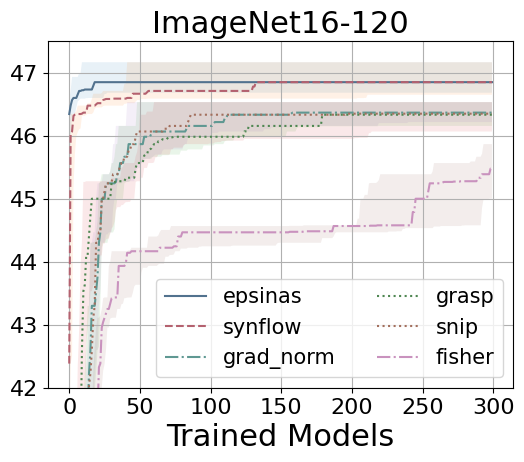

In [19]:
import seaborn as sns

filename=f'{save_dir}/integration/{dataset.upper()}/{dataset.upper()}_RS3000+RS_100it_ALL.pdf'

metrics = ['epsinas', 'synflow', 'grad_norm', 'grasp', 'snip', 'fisher']

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)

for metric in metrics:
    if metric == 'synflow':
        score = np.array(synflow)
        clr = '#B4616F'
        linesty = '--'
    elif metric == 'grad_norm':
        score = np.array(grad_norm)
        clr = '#5F9892'
        linesty = '-.'
    elif metric == 'grasp':
        score = np.array(grasp)
        clr = '#4F8752'
        linesty = ':'
    elif metric == 'snip':
        score = np.array(snip)
        clr = '#A3705E'
        linesty = ':'
    elif metric == 'fisher':
        score = np.array(fisher)
        clr = '#C992BE'
        linesty = '-.'
    elif metric == 'epsinas':
        score = np.array(epsinas)
        clr = '#52728e'
        linesty = '-'
    
    # Run NAS for a given metric
    random.seed = 21
    num_rounds = 100
    length = 300
    ae, ae_warmup, ae_move, ae_warmup_move, rand, rand_warmup = [], [], [], [], [], []
    for _ in tqdm(range(num_rounds)):
        _, rand_warmup_best_tests = run_random_search(dataset, score, max_trained_models=length, zero_cost_warmup=3000)
        rand_warmup.append(rand_warmup_best_tests)

    plot_exp(rand_warmup, metric, linesty, clr)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

plt.grid()
plt.xlabel('Trained Models', fontsize = 22)

if dataset=='cifar10':
    plt.title('CIFAR-10', fontsize = 22)
    plt.ylim(92.5,94.5)
    plt.ylabel('Test Accuracy', fontsize = 22)
elif dataset=='cifar100':
    plt.title('CIFAR-100', fontsize = 22)
    plt.ylim(67,74)
elif dataset=='ImageNet16-120':
    plt.title('ImageNet16-120', fontsize = 22)
    plt.ylim(42,47.5)

plt.legend(fontsize = 15, ncol=2)
plt.savefig(filename,
            bbox_inches='tight', 
            dpi=300,
            format='pdf')
plt.show()

100%|█████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


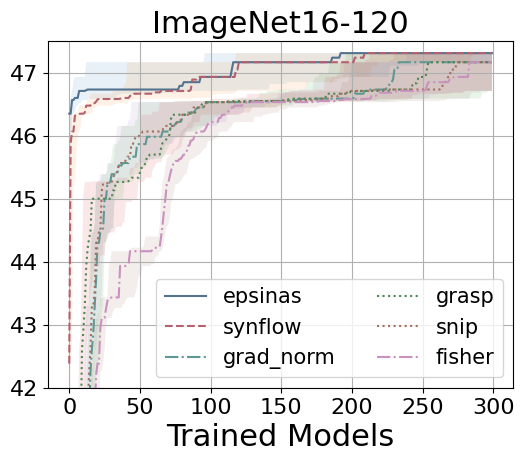

In [20]:
import seaborn as sns

filename=f'{save_dir}/integration/{dataset.upper()}/{dataset.upper()}_EA_warmup_Len300_Rounds100_ALL.pdf'

metrics = ['epsinas', 'synflow', 'grad_norm', 'grasp', 'snip', 'fisher']

fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111)

for metric in metrics:
    if metric == 'synflow':
        score = np.array(synflow)
        clr = '#B4616F'
        linesty = '--'
    elif metric == 'grad_norm':
        score = np.array(grad_norm)
        clr = '#5F9892'
        linesty = '-.'
    elif metric == 'grasp':
        score = np.array(grasp)
        clr = '#4F8752'
        linesty = ':'
    elif metric == 'snip':
        score = np.array(snip)
        clr = '#A3705E'
        linesty = ':'
    elif metric == 'fisher':
        score = np.array(fisher)
        clr = '#C992BE'
        linesty = '-.'
    elif metric == 'epsinas':
        score = np.array(epsinas)
        clr = '#52728e'
        linesty = '-'
    
    # Run NAS for a given metric
    random.seed = 21
    num_rounds = 100
    length = 300
    ae, ae_warmup, ae_move, ae_warmup_move, rand, rand_warmup = [], [], [], [], [], []
    for _ in tqdm(range(num_rounds)):
        _, ae_warmup_best_tests = run_evolution_search(dataset, score, max_trained_models=length, zero_cost_warmup=3000)
        ae_warmup.append(ae_warmup_best_tests)

    plot_exp(ae_warmup, metric, linesty, clr)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

plt.grid()
plt.xlabel('Trained Models', fontsize = 22)

if dataset=='cifar10':
    plt.title('CIFAR-10', fontsize = 22)
    plt.ylim(92.5,94.5)
    plt.ylabel('Test Accuracy', fontsize = 22)
elif dataset=='cifar100':
    plt.title('CIFAR-100', fontsize = 22)
    plt.ylim(67,74)
elif dataset=='ImageNet16-120':
    plt.title('ImageNet16-120', fontsize = 22)
    plt.ylim(42,47.5)


plt.legend(fontsize = 15, ncol=2)
plt.savefig(filename,
            bbox_inches='tight', 
            dpi=300,
            format='pdf')
plt.show()